## Задача:

    Используя метод логистической регрессии из библиотеки PyTorch
    решить задачу классификации рукописных цифр из базы MNIST.

In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.autograd import Variable

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    Смотрим на данные.

In [4]:
print(train_dataset, '\n\n', test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None 

 Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


		 label:  4


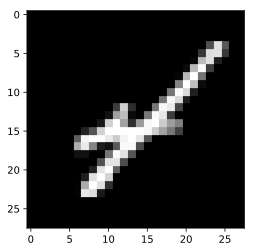

		 (28, 28) px


In [23]:
num_examples = 60000
ix = np.random.randint(train_size)
print('\t\t', 'label: ', train_dataset.train_labels[ix].item())
image = train_dataset.train_data[ix]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print('\t\t', image.shape, 'px')

In [24]:
occs = []
for i in range(10):
    occ = np.count_nonzero(train_dataset.train_labels == i)
    print ("digit", i, "appear", occ, "times")
    occs.append(occ)
mean = [float(int(occ/num_examples*100))/100 for occ in occs]

digit 0 appear 5923 times
digit 1 appear 6742 times
digit 2 appear 5958 times
digit 3 appear 6131 times
digit 4 appear 5842 times
digit 5 appear 5421 times
digit 6 appear 5918 times
digit 7 appear 6265 times
digit 8 appear 5851 times
digit 9 appear 5949 times


## О методе логистической регрессии (one vs all)

В основе метода лежит идея о том, что совокупности объектов, относящихся к двум разным классам, будучи представленными точками в многомерном пространстве признаков могут быть разделены гиперплоскостью. Предположим, что мы уже получили веса модели $ \vec{w_{}} $, и она должна давать нам вероятность $ p_{+} $ принадлежности объекта к заданному классу (+), при условии, что тот обладает набором объясняющих признаков $ \vec{x_i} $:

<center> $ \large{p_{+}(\vec{x_i})=\mathbb{P}}\bigl( y=y_i \mid \vec{x_i}, \vec{w_{}} \bigr) $ </center>

Определим отношение вероятностей (odds ratio) $ OR(X) = \frac{\mathbb{P}(X)}{1-\mathbb{P}(X)} $, с множеством значений в $ [0,\infty) $. Поскольку нас интересует отображение значений в $ [0,1] $, будем использовать функцию вида $ f(x) = \frac{1}{1+e^{-x}} $. Получается она, если взять логарифм отношения шансов $ \log(OR_{+}) = \vec{w_{}}^{T}\vec{x_{}} $ и вычислить вероятность принадлежности объекта заданному классу по следующей формуле:

<center> $ \large{p_{+}(\vec{x_i})=\frac{OR_{+}}{1+OR_{+}}} = \frac{\exp(\vec{w_{}}^{T}\vec{x_{}})}{1+\exp(\vec{w_{}}^{T}\vec{x_{}})} = \frac{1}{1+\exp(-\vec{w_{}}^{T}\vec{x_{}})} $ </center>

Вероятность наблюдать распределение $ \vec{y_{}} $ объектов выборки $ X $ по классам (правдоподобие) выглядит так:

<center> $ \large{\mathbb{P}(\vec{y_{}} \mid X, \vec{w_{}}) = \prod_{i=1}^{p}\mathbb{P}(y=y_i \mid \vec{x_{i}}, \vec{w_{}})} $ </center>

Логарифмируя и пользуясь логарифмическими удобствами, получаем:

<center> $ \large{\mathbb{P}(\vec{y_{}} \mid X, \vec{w_{}}) = -\sum_{i=1}^{p}\log(1+\exp(-\vec{y_i} \vec{w_{}}^T \vec{x_i}))} $ </center>

Без минуса будет логистическая функция потерь. Её и будем минимизировать.

Обобщение на мультиномиальную логрегрессию производится следующим образом. Пусть количество категорий классификации равно $ M $. <br> Для классификации по каждому из классов $ k \in M $ запишем $ M - 1 $ логарифмов отношений шансов, где $ m \in M \setminus \{ k \} $ классов:

<center> $ \Large{\log{\frac{\mathbb{P}(y_i = 1)}{\mathbb{P}(y_i = M)}} = \vec{w_{1}}^T\vec{x_i}} $ </center>
<center> $ \Large{\log{\frac{\mathbb{P}(y_i = 2)}{\mathbb{P}(y_i = M)}} = \vec{w_{2}}^T\vec{x_i}} $ </center>
<center> $ \dots $ </center>
<center> $ \Large{\log{\frac{\mathbb{P}(y_i = M-1)}{\mathbb{P}(y_i = M)}} = \vec{w_{}}_{M-1}^T\vec{x_i}} $ </center>

Соответственно,

<center> $ \Large{\mathbb{P}(y_i=1) = \mathbb{P}(y_i=M) \exp{\vec{w_1}^T \vec{x_i}} }$ </center>
<center> $ \Large{\mathbb{P}(y_i=2) = \mathbb{P}(y_i=M) \exp{\vec{w_2}^T \vec{x_i}} }$ </center>
<center> $ \dots $ </center>
<center> $ \Large{\mathbb{P}(y_i=M-1) = \mathbb{P}(y_i=M) \exp{\vec{w_{}}_{M-1}^T \vec{x_i}} }$ </center>

<br>

<center> $ \Large{\mathbb{P}(y_i=M) = 1 - \sum_{m=1}^{M-1}{\mathbb{P}(y_i = m}) = } $ </center>

<br>

<center> $ \Large{1 - \sum_{m=1}^{M-1}{\mathbb{P}(y_i = M) \exp{\vec{w_m}^T \vec{x_i}}}} \Rightarrow  $ </center>

<br>

<center> $ \Large{\mathbb{P}(y_i = M}) = \frac{1}{1 + \sum\limits_{m =1}^{M-1} \exp{\vec{w_{m}}^T\vec{x_i}}} $ </center>

Логарифмируя, опять получим функцию потерь со знаком минус, на этот раз уже для мультиномиальной регресии.

### Softmax-классификатор

Информационная энтропия определяется, как ожидаемое количество бит информации кодирующих событие, при условии, что оно кодируется оптимально:

$ \large{H(y) = \sum\limits_i{\log{y_i\frac{1}{y_i}}} = -\sum\limits_i{y_i\log{y_i}}} $ где $ y_i $ — вероятность события $ i $ из распределения $ y $.

Пусть $ y $ — распределение истинного набора меток, а $ \widehat{y} $ — распределение, которое даёт наша модель. Тогда кросс-энтропией называется количество бит, кодирующих событие $ y_i $ из $ y $ с помощью распределения $ \widehat{y} $:

$ \large{H(y, \widehat{y}) = \sum\limits_i{\log{y_i\frac{1}{\widehat{y}_i}}} = -\sum\limits_i{y_i\log{\widehat{y}_i}}} $

***

Запишем функцию распределения для $ y $:

<center> $ \large{p(x|\pi) = \Large{\frac{M!}{x_1! \dots x_K!}}} \pi_1^{x_1} \dots \pi_k^{x_k} $ </center>

Приведем в каноническую форму функции из экспоненциального семейства:

<center> $ \large{p(x|\pi) = \Large{\frac{M!}{x_1! \dots x_K!}}} \exp{\{\log{\pi_1^{x_1} \dots \pi_k^{x_k}\}} = \Large{\frac{M!}{x_1! \dots x_K!}}} \exp{\{\sum\limits_{k=1}^{K}{{x_k}\log{\pi_k}\}}} $ </center>

Рассмотрим подэкспоненциальное выражение:

<center> $ \large{\sum\limits_{k=1}^{K}{{x_k}\log{\pi_k}}} = \large{\sum\limits_{k=1}^{K-1}{{x_k}\log{\pi_k}}} + (1 - \sum\limits_{k=1}^{K-1}{x_k})\log{(1 - \sum\limits_{k=1}^{K-1}{\pi_k})} = \sum\limits_{k=1}^{K-1}{\log{\Large{\frac{\pi_k}{1 - \sum_{k=1}^{K-1}{\pi_k}}}} x_k } + \log\bigl({1 - \sum\limits_{k=1}^{K}{\pi_k}\bigr)} $ </center>

где

<center> $ \large{\eta_k} = \log{\Large{\frac{\pi_k}{1 - \sum_{k=1}^{K-1}{\pi_k}}}} = \log{\Large{\frac{\pi_k}{\pi_K}}} \quad \Rightarrow \quad \pi_k = \Large{\frac{e^{\eta_k}}{\sum\limits_{j=1}^{K}{e^{\eta_j}}}} $ </center>